## Импорт данных

In [1]:
from tensorflow.keras.datasets import cifar10

In [2]:
(x_train, y_train), (x_test, y_test)=cifar10.load_data()

In [3]:
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape)) 
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


## Нормализация и создание фиктивных переменных (One-hot-encoding)

In [4]:
from tensorflow.keras.utils import to_categorical

# Нормализация
x_train=x_train/255
x_test=x_test/255

#One hot encoding
y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)

In [5]:
# Импорт необходимых библиотек, которыми мы можем воспользоваться
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Модели

### Базовая модель
Два простых сверточных слоя с 32 фильтрами в каждом, а входная форма равна 32х32х3. Функция активации - ReLu

In [6]:
model1=Sequential()
model1.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(256,activation='relu'))
model1.add(Dense(10,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

In [8]:
history1=model1.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat))

Epoch 1/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.5141 - accuracy: 0.4510 - val_loss: 1.2942 - val_accuracy: 0.5440
Epoch 2/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2001 - accuracy: 0.5756 - val_loss: 1.1649 - val_accuracy: 0.5875
Epoch 3/20
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0496 - accuracy: 0.6327 - val_loss: 1.0771 - val_accuracy: 0.6207
Epoch 4/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9446 - accuracy: 0.6707 - val_loss: 1.0321 - val_accuracy: 0.6425
Epoch 5/20
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8551 - accuracy: 0.7008 - val_loss: 1.0065 - val_accuracy: 0.6560
Epoch 6/20
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7752 - accuracy: 0.7304 - val_loss: 0.9745 - val_accuracy: 0.6687
Epoch 7/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7063 - accuracy: 0.7546 - val_loss: 0.9697 -

In [9]:
evaluation = model1.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 2s 5ms/step - loss: 1.9394 - accuracy: 0.6528
Test Accuracy: 0.6528000235557556


<AxesSubplot:>

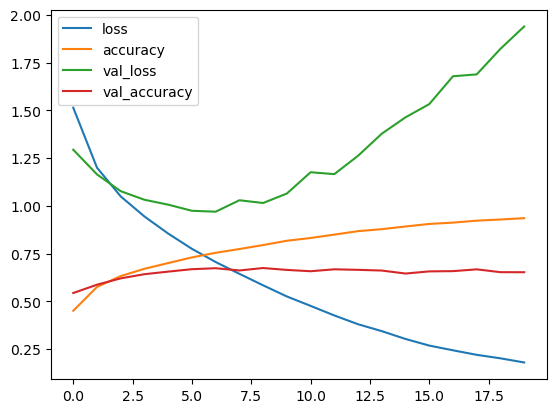

In [10]:
import pandas as pd
pd.DataFrame(history1.history).plot()

Используя данную базовую модель мы смогли получить 93% точности обучения и 65% точности тестирования, что является недостаточно высоким результатом. 

Мы также можем заметить, что при потери при проверки значительно увеличиваются, что означает, что наша модель "переобучается". Это означает, что она хорошо работает с обучающим набором данных, но не может обощить "невидимые" данные.

Как уменьшить переобучение? Я нахожу следующие варианты:

1. Добавить больше данных
2. Уменьшить сложность модели
3. Применить регуляризацию

Варианты 1 и 2 в нашем случае не подходят, поскольку получить новые данные очень сложно, а сама наша модель не настолько сложна, чтобы уменьшить архитектуру. 

Будем использовать метод регуляризации - Dropout.

Случайным образом мы удалим некоторые нейронные единицы из нашей сети, что заставит следующий уровень снова изучать паттерны. 

Попробуем добавить Dropout после каждого слоя CNN + MaxPool.

### Модель с методом регуляризации Dropout

In [11]:
model2=Sequential()
model2.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25)) # Убираем 25% изучаемых объектов со слоя
model2.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(10,activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
history2=model2.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat))

Epoch 1/20
1563/1563 [==============================] - 30s 19ms/step - loss: 1.5742 - accuracy: 0.4292 - val_loss: 1.3114 - val_accuracy: 0.5271
Epoch 2/20
1563/1563 [==============================] - 29s 19ms/step - loss: 1.2669 - accuracy: 0.5498 - val_loss: 1.1377 - val_accuracy: 0.6042
Epoch 3/20
1563/1563 [==============================] - 27s 18ms/step - loss: 1.1221 - accuracy: 0.6020 - val_loss: 1.0665 - val_accuracy: 0.6257
Epoch 4/20
1563/1563 [==============================] - 31s 20ms/step - loss: 1.0279 - accuracy: 0.6357 - val_loss: 1.0100 - val_accuracy: 0.6486
Epoch 5/20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9558 - accuracy: 0.6634 - val_loss: 0.9570 - val_accuracy: 0.6688
Epoch 6/20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9002 - accuracy: 0.6835 - val_loss: 0.9071 - val_accuracy: 0.6871
Epoch 7/20
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8557 - accuracy: 0.6998 - val_loss: 0.8977 -

In [13]:
evaluation = model2.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.8931 - accuracy: 0.7137
Test Accuracy: 0.713699996471405


<AxesSubplot:>

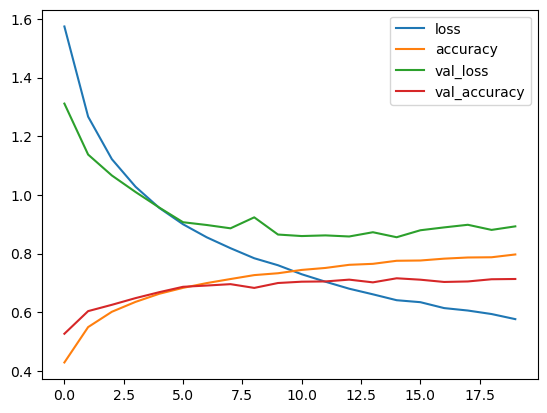

In [14]:
pd.DataFrame(history2.history).plot()

Мы наблюдаем повышение точности с 64% до 71%.

Попробуем добавить большее количество слоев с увеличением количества фильтров.
Также, потери теперь находятся под контролем, поэтому мы можем использовать большее количество эпох.

### Модель с Dropout с большим количеством слоев и фильтров

In [15]:
model3 = Sequential()
model3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape = (32,32,3)))
model3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.4))


model3.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model3.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.4))

model3.add(Flatten())

model3.add(Dense(units = 1024, activation = 'relu'))

model3.add(Dense(units = 1024, activation = 'relu'))

model3.add(Dense(units = 10, activation = 'softmax'))
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [16]:
history3=model3.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 193s 123ms/step - loss: 1.5764 - accuracy: 0.4182 - val_loss: 1.2520 - val_accuracy: 0.5552
Epoch 2/50
1563/1563 [==============================] - 204s 130ms/step - loss: 1.2278 - accuracy: 0.5603 - val_loss: 1.0770 - val_accuracy: 0.6164
Epoch 3/50
1563/1563 [==============================] - 205s 131ms/step - loss: 1.0772 - accuracy: 0.6178 - val_loss: 1.0067 - val_accuracy: 0.6445
Epoch 4/50
1563/1563 [==============================] - 202s 130ms/step - loss: 0.9648 - accuracy: 0.6592 - val_loss: 0.8740 - val_accuracy: 0.6907
Epoch 5/50
1563/1563 [==============================] - 177s 113ms/step - loss: 0.8840 - accuracy: 0.6864 - val_loss: 0.8165 - val_accuracy: 0.7132
Epoch 6/50
1563/1563 [==============================] - 182s 117ms/step - loss: 0.8171 - accuracy: 0.7096 - val_loss: 0.7925 - val_accuracy: 0.7305
Epoch 7/50
1563/1563 [==============================] - 189s 121ms/step - loss: 0.7618 - accuracy: 0.7308 - val_

Мы видим, что увеличение слоев и увеличение dropout с 0.25 до 0.4 привело к повышению точности 76%, что является значительным улучшением. 

Можно попробовать увеличить количество слоев. Однако если мы будем добавлять дальше CNN мы потеряем данные, так как размер изображений уменьшится из-за свертки. Изображения у нас небольшие - поэтому хорошей идеей будет ограничить количество слоев.

<AxesSubplot:>

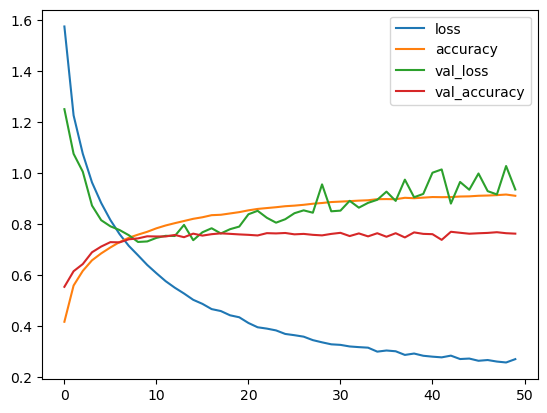

In [17]:
pd.DataFrame(history3.history).plot()

### Модель с увеличенным количеством слоев и фильтров наряду с увеличевающимся Dropout

In [21]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model4.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(MaxPool2D((2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(MaxPool2D((2, 2)))
model4.add(Dropout(0.3))
model4.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(MaxPool2D((2, 2)))
model4.add(Dropout(0.4))
model4.add(Flatten())
model4.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dropout(0.5))
model4.add(Dense(10, activation='softmax'))

# compile model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history4=model4.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 115s 73ms/step - loss: 1.7309 - accuracy: 0.3535 - val_loss: 1.4099 - val_accuracy: 0.4966
Epoch 2/50
1563/1563 [==============================] - 130s 83ms/step - loss: 1.3079 - accuracy: 0.5286 - val_loss: 1.1140 - val_accuracy: 0.6026
Epoch 3/50
1563/1563 [==============================] - 134s 86ms/step - loss: 1.1215 - accuracy: 0.6023 - val_loss: 0.9180 - val_accuracy: 0.6716
Epoch 4/50
1563/1563 [==============================] - 139s 89ms/step - loss: 1.0215 - accuracy: 0.6437 - val_loss: 0.8491 - val_accuracy: 0.7035
Epoch 5/50
1563/1563 [==============================] - 140s 89ms/step - loss: 0.9525 - accuracy: 0.6694 - val_loss: 0.8380 - val_accuracy: 0.7110
Epoch 6/50
1563/1563 [==============================] - 139s 89ms/step - loss: 0.9016 - accuracy: 0.6878 - val_loss: 0.7811 - val_accuracy: 0.7275
Epoch 7/50
1563/1563 [==============================] - 137s 88ms/step - loss: 0.8647 - accuracy: 0.7016 - val_loss: 0

<AxesSubplot:>

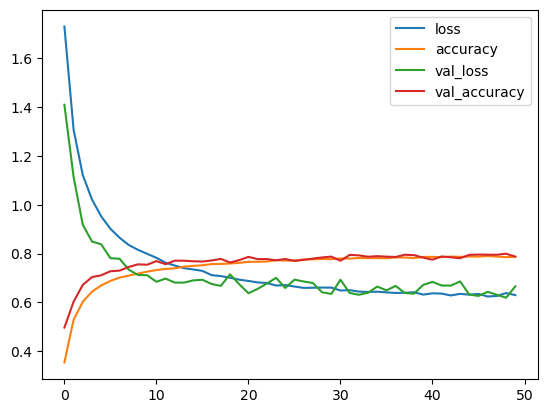

In [23]:
pd.DataFrame(history4.history).plot()

In [24]:
evaluation = model4.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 6s 20ms/step - loss: 0.6655 - accuracy: 0.7873
Test Accuracy: 0.7872999906539917


Теперь точность составила 78%.

### Batch Normalization для ускорения обучения нейронных сетей

In [27]:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPool2D((2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPool2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPool2D((2, 2)))
model5.add(Dropout(0.4))
model5.add(Flatten())
model5.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(10, activation='softmax'))

# compile model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history5=model5.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 161s 102ms/step - loss: 1.5900 - accuracy: 0.4484 - val_loss: 1.1553 - val_accuracy: 0.5967
Epoch 2/50
1563/1563 [==============================] - 149s 96ms/step - loss: 1.0582 - accuracy: 0.6263 - val_loss: 0.8461 - val_accuracy: 0.7011
Epoch 3/50
1563/1563 [==============================] - 150s 96ms/step - loss: 0.9016 - accuracy: 0.6883 - val_loss: 0.8427 - val_accuracy: 0.7112
Epoch 4/50
1563/1563 [==============================] - 149s 95ms/step - loss: 0.7957 - accuracy: 0.7259 - val_loss: 0.6886 - val_accuracy: 0.7650
Epoch 5/50
1563/1563 [==============================] - 146s 94ms/step - loss: 0.7208 - accuracy: 0.7543 - val_loss: 0.6696 - val_accuracy: 0.7726
Epoch 6/50
1563/1563 [==============================] - 140s 90ms/step - loss: 0.6691 - accuracy: 0.7717 - val_loss: 0.5734 - val_accuracy: 0.8051
Epoch 7/50
1563/1563 [==============================] - 140s 90ms/step - loss: 0.6132 - accuracy: 0.7912 - val_loss: 

<AxesSubplot:>

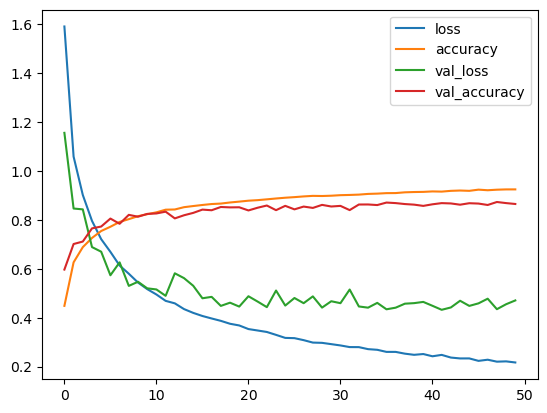

In [29]:
pd.DataFrame(history5.history).plot()

In [30]:
evaluation = model5.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 7s 21ms/step - loss: 0.4706 - accuracy: 0.8647
Test Accuracy: 0.8647000193595886


Данная нормализация дает хорошие результаты. Точность проверки 86%. 

### Модель с аугментацией изображения

Добавление большего количества данных уменьшит переобучение. Мы можем генерировать данные из уже имеющихся путем некоторого изменения изображений. Будем использовать для этого ImageDataGenerator.

In [31]:
model6 = Sequential()
model6.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model6.add(BatchNormalization())
model6.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPool2D((2, 2)))
model6.add(Dropout(0.2))
model6.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPool2D((2, 2)))
model6.add(Dropout(0.3))
model6.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPool2D((2, 2)))
model6.add(Dropout(0.4))
model6.add(Flatten())
model6.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))
model6.add(Dense(10, activation='softmax'))

# compile model
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Мы сдвигаем изображение по ширине и высоте, а также переворачиваем изображение по горизонтали
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,rotation_range=20)
it_train = datagen.flow(x_train,y_train_cat)
steps = int(x_train.shape[0] / 64)

In [33]:
history6=model6.fit_generator(it_train,epochs=200,steps_per_epoch=steps,validation_data=(x_test,y_test_cat))

Epoch 1/200


C:\Users\kirkf\AppData\Local\Temp\ipykernel_18940\1569698052.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6=model6.fit_generator(it_train,epochs=200,steps_per_epoch=steps,validation_data=(x_test,y_test_cat))


781/781 [==============================] - 87s 108ms/step - loss: 1.9767 - accuracy: 0.3291 - val_loss: 1.4053 - val_accuracy: 0.4854
Epoch 2/200
781/781 [==============================] - 81s 103ms/step - loss: 1.4989 - accuracy: 0.4529 - val_loss: 1.4874 - val_accuracy: 0.4830
Epoch 3/200
781/781 [==============================] - 80s 102ms/step - loss: 1.3402 - accuracy: 0.5187 - val_loss: 1.1082 - val_accuracy: 0.6129
Epoch 4/200
781/781 [==============================] - 80s 103ms/step - loss: 1.2199 - accuracy: 0.5654 - val_loss: 1.0559 - val_accuracy: 0.6218
Epoch 5/200
781/781 [==============================] - 80s 102ms/step - loss: 1.1551 - accuracy: 0.5915 - val_loss: 1.1309 - val_accuracy: 0.6065
Epoch 6/200
781/781 [==============================] - 80s 103ms/step - loss: 1.0711 - accuracy: 0.6251 - val_loss: 0.8914 - val_accuracy: 0.6826
Epoch 7/200
781/781 [==============================] - 80s 102ms/step - loss: 1.0244 - accuracy: 0.6448 - val_loss: 0.8898 - val_accurac

781/781 [==============================] - 75s 96ms/step - loss: 0.5546 - accuracy: 0.8115 - val_loss: 0.4836 - val_accuracy: 0.8382
Epoch 58/200
781/781 [==============================] - 75s 97ms/step - loss: 0.5322 - accuracy: 0.8207 - val_loss: 0.4809 - val_accuracy: 0.8419
Epoch 59/200
781/781 [==============================] - 76s 97ms/step - loss: 0.5409 - accuracy: 0.8170 - val_loss: 0.4937 - val_accuracy: 0.8380
Epoch 60/200
781/781 [==============================] - 75s 96ms/step - loss: 0.5399 - accuracy: 0.8169 - val_loss: 0.4801 - val_accuracy: 0.8407
Epoch 61/200
781/781 [==============================] - 76s 97ms/step - loss: 0.5335 - accuracy: 0.8222 - val_loss: 0.4276 - val_accuracy: 0.8600
Epoch 62/200
781/781 [==============================] - 75s 96ms/step - loss: 0.5361 - accuracy: 0.8177 - val_loss: 0.4322 - val_accuracy: 0.8515
Epoch 63/200
781/781 [==============================] - 75s 96ms/step - loss: 0.5341 - accuracy: 0.8215 - val_loss: 0.4339 - val_accuracy

781/781 [==============================] - 75s 96ms/step - loss: 0.4638 - accuracy: 0.8421 - val_loss: 0.3882 - val_accuracy: 0.8701
Epoch 114/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4561 - accuracy: 0.8469 - val_loss: 0.4484 - val_accuracy: 0.8529
Epoch 115/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4590 - accuracy: 0.8445 - val_loss: 0.3835 - val_accuracy: 0.8705
Epoch 116/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4606 - accuracy: 0.8427 - val_loss: 0.4007 - val_accuracy: 0.8650
Epoch 117/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4602 - accuracy: 0.8448 - val_loss: 0.4114 - val_accuracy: 0.8639
Epoch 118/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4550 - accuracy: 0.8441 - val_loss: 0.3750 - val_accuracy: 0.8752
Epoch 119/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4465 - accuracy: 0.8531 - val_loss: 0.4025 - val_ac

Epoch 169/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4216 - accuracy: 0.8588 - val_loss: 0.3760 - val_accuracy: 0.8762
Epoch 170/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4174 - accuracy: 0.8606 - val_loss: 0.3603 - val_accuracy: 0.8798
Epoch 171/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4220 - accuracy: 0.8548 - val_loss: 0.3834 - val_accuracy: 0.8729
Epoch 172/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4109 - accuracy: 0.8618 - val_loss: 0.4005 - val_accuracy: 0.8702
Epoch 173/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4169 - accuracy: 0.8599 - val_loss: 0.3584 - val_accuracy: 0.8795
Epoch 174/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4174 - accuracy: 0.8589 - val_loss: 0.3634 - val_accuracy: 0.8784
Epoch 175/200
781/781 [==============================] - 75s 96ms/step - loss: 0.4095 - accuracy: 0.8607 - val_loss: 0

In [36]:
evaluation = model6.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 7s 21ms/step - loss: 0.4228 - accuracy: 0.8643
Test Accuracy: 0.864300012588501


По данным результатам аугментация изображения не принесла ожидаемого эффекта. Возможно следует увеличить количество эпох или уменьшить значения аугментации. В общем есть смысл поэксперементировать, чтобы увеличить точность нашей модели.